In [284]:
import uproot as up
import awkward as ak
import vector
vector.register_awkward()
import numpy as np
from matplotlib import pyplot as plt
from gbdt import preprocess, train
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from applyCorrections import apply_corrections

In [285]:
def getBranch(data, l1jet):
    
    # Get list of branches relating to the given jet
    interestingBranches = [branch for branch in data.keys() if l1jet in branch and not f"n{l1jet}" in branch]# and not f"{l1jet}_dau0" in branch] 
    
    # Get only branches corresponding to the desired l1jet
    l1jetData = data.arrays(interestingBranches)
    
    # Get a dictionary relating default branch names to new branch names (ie without leading ak8PuppiJets_...)
    renamedFields = {field : field.split('_', maxsplit=1)[-1] for field in interestingBranches}

    # Create a new awkward array with the desired l1jet branches and the new branch names
    arr = ak.Array({renamedFields[field]: l1jetData[field] for field in l1jetData.fields})
    
    array_dict = {key: arr[key] for key in arr.fields}
    quarks4mom = ak.zip(array_dict)
    quarks4mom = ak.with_name(quarks4mom, "Momentum4D")
    
    return quarks4mom

# Signal

In [286]:
sig = up.open("/eos/user/l/lroberts/Jet_Mass/CMSSW_14_2_0_pre2/src/FastPUPPI/condor/jobs/lightHbb_M20to80_Pt50to200_1741980301/data/lightHbb_M20to80_Pt50to200.root")["Events"]

In [287]:
sig_jets = getBranch(sig, "sc8PuppiEmuJets_")
sig_jets = ak.with_field(sig_jets, np.sqrt(sig_jets.mass), where="mass")

# Background

In [288]:
bkg = up.open("/eos/home-l/lroberts/Jet_Mass/CMSSW_14_2_0_pre2/src/FastPUPPI/condor/jobs/Phase2Spring24_SingleNeutrino_NoDau_PU200_1742483212/data/SingleNeutrino_NoDau_PU200.root")["Events"]

In [289]:
bkg_jets = getBranch(bkg, "sc8PuppiEmuJets_")
bkg_jets = ak.with_field(bkg_jets, np.sqrt(bkg_jets.mass), where="mass")

# Prepare training data

In [290]:
sig_train, sig_test = sig_jets[:13500], sig_jets[13500:]

In [291]:
bkg_train, bkg_test = bkg_jets[:0], bkg_jets[13500:]

In [292]:
def preprocess(jets):
    jets = jets[(jets.mass > 0)]    # Remove unmatched jets and 0 mass jets
    jets = ak.with_field(jets, jets.genmass / jets.mass, where="sf")
#     jets_flat = ak.firsts(jets)
    jets_flat = ak.flatten(jets)
#     jets_flat = jets_flat[~ak.is_none(jets_flat)]
    
    X = np.array( np.column_stack( (jets_flat.pt, jets_flat.eta, jets_flat.mass, jets_flat.nDau) ) )
    y =  np.array( ak.to_numpy(jets_flat.sf) )
    
    return X, y

In [293]:
X_sig_train, y_sig_train = preprocess(sig_train)

In [294]:
X_bkg_train, y_bkg_train = preprocess(bkg_train)

In [295]:
X_train = np.row_stack([X_sig_train, X_bkg_train])
y_train = np.concatenate([y_sig_train, y_bkg_train])

# Testing BDTs

## BDT 3

In [296]:
regressor = XGBRegressor(
#     n_estimators=200,    # Number of trees
#     learning_rate=0.05,  # Step size shrinkage
#     max_depth=6,         # Maximum depth of a tree
#     subsample=0.8,       # Use 80% of data for training each tree
#     colsample_bytree=0.8, # Use 80% of features per tree
#     objective="reg:squarederror", # Loss function for regression
#     random_state=42
)

regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [297]:
regressor.feature_importances_

array([0.3546304 , 0.1244459 , 0.4142709 , 0.10665274], dtype=float32)

In [313]:
regressor.save_model("model.json")

In [298]:
sig_uncorr, bkg_uncorr = apply_corrections(sig_test, None), apply_corrections(bkg_test, None)

In [299]:
sig_corr, bkg_corr = apply_corrections(sig_test, regressor), apply_corrections(bkg_test, regressor)

# Plotting

In [300]:
def resolution(jets):

    plt.figure(figsize=(12,8))
    bins = np.linspace(-1.5, 3, 16)

    labels = ["Uncorrected L1 mass", "BDT corrected L1 mass", "train sample"]
    i=0
    for jet in jets:
        plt.hist( jet.mass_corr / jet.genmass, bins=bins, histtype="step", label=labels[i], density=True )
        i+=1

    plt.xlabel("Response", fontsize=16)
    plt.xlim(-1,3)
    plt.xticks(fontsize=12); plt.yticks(fontsize=12)
    plt.grid()
    plt.title("0 GeV < genmass < 10 GeV", fontsize=16)
    plt.legend(fontsize=12)
    plt.show()

In [328]:
def res(jets, var="pt"):
    plt.figure(figsize=(12,8))
    
    genvar = var.split("_")[0]
    bins = np.linspace(0, 100, 11) if genvar=="mass" else np.linspace(0, 300, 13)
    xs = bins[:-1] + (bins[1] / 2)
    xerr = (bins[-1] - bins[-2])/2
    labels=["Uncorrected signal", "Corrected signal", "Uncorrected background", "Corrected background"]
    i=0
    for jet in jets:
        ys = []
        yerrs = []
        for b in range(len(bins)-1):
            genvar = var.split("_")[0]
            mask = (jet[f"gen{genvar}"] >= bins[b]) & (jet[f"gen{genvar}"] < bins[b+1])
            jetsInBin = jet[mask]
            
            response = jetsInBin[f"{var}"] / (jetsInBin[f"gen{genvar}"]+0.00001)
            response = response[~np.isnan(response)]
            
            mean = np.mean( response )
            stddev = np.std( response )    #stddev / np.sqrt(2*(len( resolutions )-1))
            mean_err = stddev / np.sqrt( len(response) )
            stddev_err = stddev / np.sqrt(2*(len( response )-1))
            
            ys.append( stddev )
            yerrs.append( stddev_err )

        plt.errorbar(xs, ys, xerr=xerr, yerr=yerrs, fmt="o", capsize=5, label=labels[i])
        i+=1
    
    plt.axhline(0, color="black", linestyle="--")
    plt.title(f"{var} response as a function of gen {genvar}", fontsize=16)
    plt.xlabel(f"Gen {genvar} (GeV)", fontsize=16); plt.ylabel(f"Response standard deviation", fontsize=16)
    plt.xticks(bins, fontsize=12); plt.yticks(np.linspace(0,1,9), fontsize=12)
    plt.xlim(bins[0], bins[-1]); plt.ylim(-0.05, 1)
    plt.grid()
    plt.legend(fontsize=12)
    plt.show()

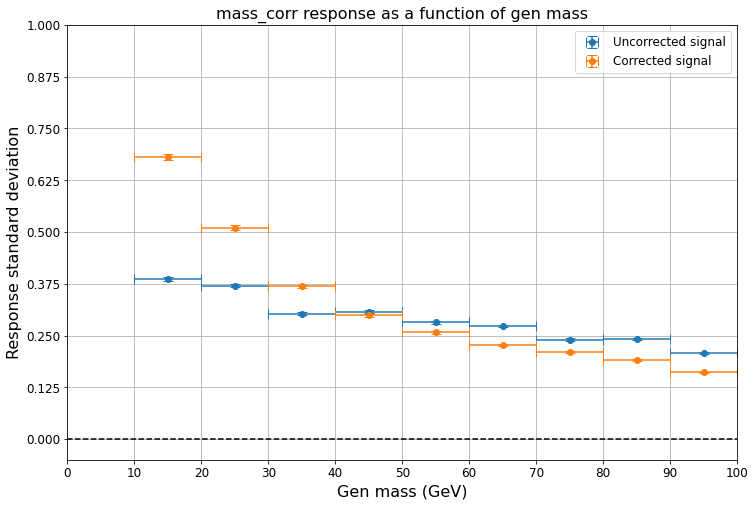

In [329]:
res([sig_uncorr, sig_corr], "mass_corr")

In [334]:
def plot2d(jets):
    fig, axs = plt.subplots(1, 2, figsize=(24, 12), facecolor="white")
    ax1, ax2 = axs
    
    nBins=50
    pt, mass, mass_corr = ak.to_numpy( ak.firsts(jets).pt ), ak.to_numpy( ak.firsts(jets).mass ), ak.to_numpy( ak.firsts(jets).mass_corr )
    plot1 = ax1.hist2d(pt, mass, bins=50, range=[[0, 600], [0, 150]], cmap='viridis')
    plot2 = ax2.hist2d(pt, mass_corr, bins=nBins, range=[[0, 600], [0, 150]], cmap='viridis')
    
    vmin = 1
    vmax = max(plot1[0].max(), plot2[0].max())

    # Replot with the same color scale
    ax1.clear()
    ax2.clear()
    plot1 = ax1.hist2d(pt, mass, bins=nBins, range=[[0, 600], [0, 150]], norm=LogNorm(vmin=vmin, vmax=vmax), cmap='viridis')
    plot2 = ax2.hist2d(pt, mass_corr, bins=nBins, range=[[0, 600], [0, 150]], norm=LogNorm(vmin=vmin, vmax=vmax), cmap='viridis')
    
    fig.colorbar(plot1[3], ax=ax1, label="Density (log scale)", pad=0.01)
    fig.colorbar(plot2[3], ax=ax2, label="Density (log scale)", pad=0.01)
    
    ax1.grid(); ax2.grid()
    ax1.set_xlabel("Uncorrected pT (GeV)", fontsize=16); ax2.set_xlabel("Uncorrected pT (GeV)", fontsize=16)
    ax1.set_ylabel("Uncorrected mass (GeV)", fontsize=16); ax2.set_ylabel("Corrected mass (GeV)", fontsize=16)
    xt, yt = np.linspace(0, 600, 13), np.linspace(0, 150, 16)
    ax1.set_xticks(xt); ax2.set_xticks(xt)
    ax1.set_yticks(yt); ax2.set_yticks(yt)
    ax1.set_title("Uncorrected mass", fontsize=16); ax2.set_title("Corrected mass", fontsize=16)
    
    plt.suptitle("Mixed light H --> bb sample, Higgs (pT, mass) combinations: ((20, 50), (40, 100), (60, 150) and (80, 200)), total events: 17,500", fontsize=20)
#     plt.suptitle("Single neutrino @ PU200, total events: 1,979,460", fontsize=20)
    
    plt.show()

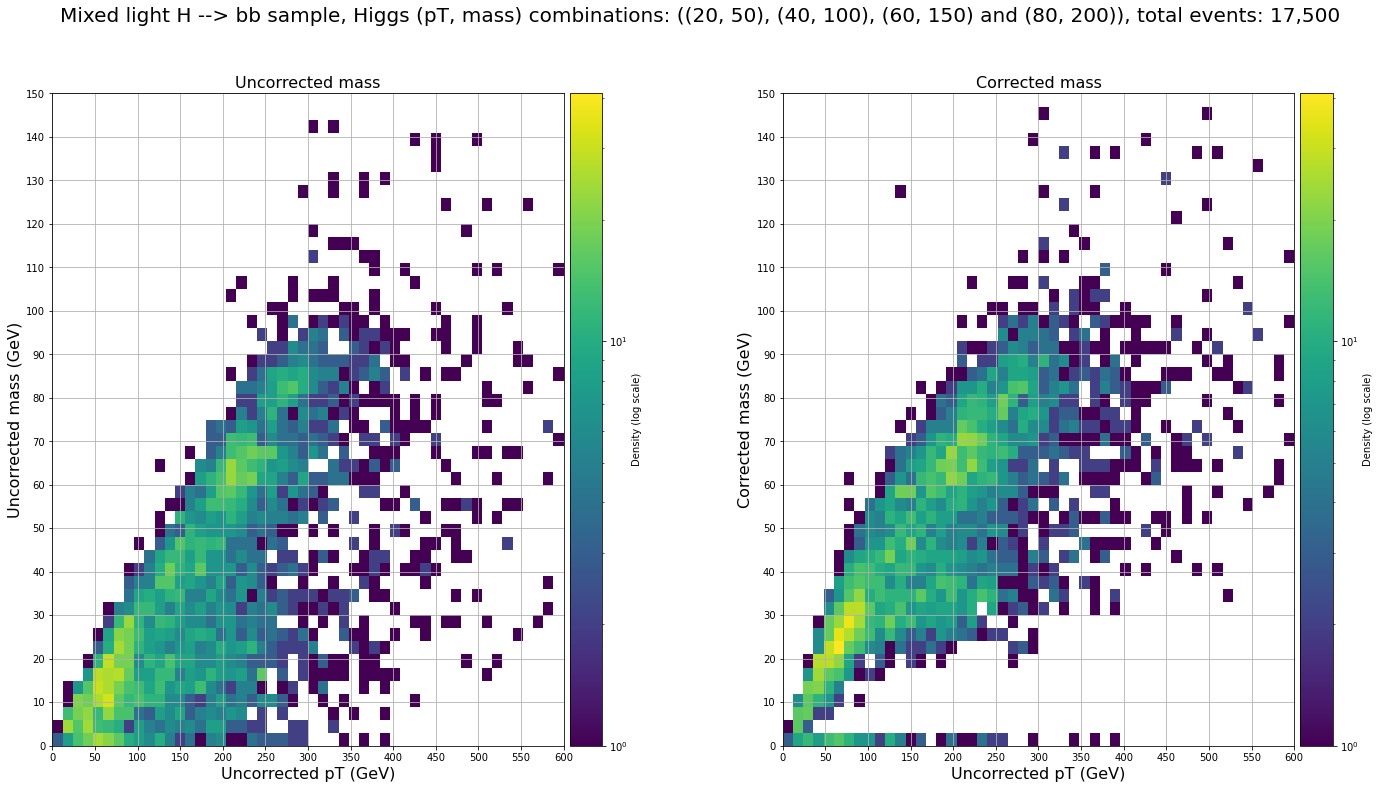

In [335]:
plot2d(sig_corr)

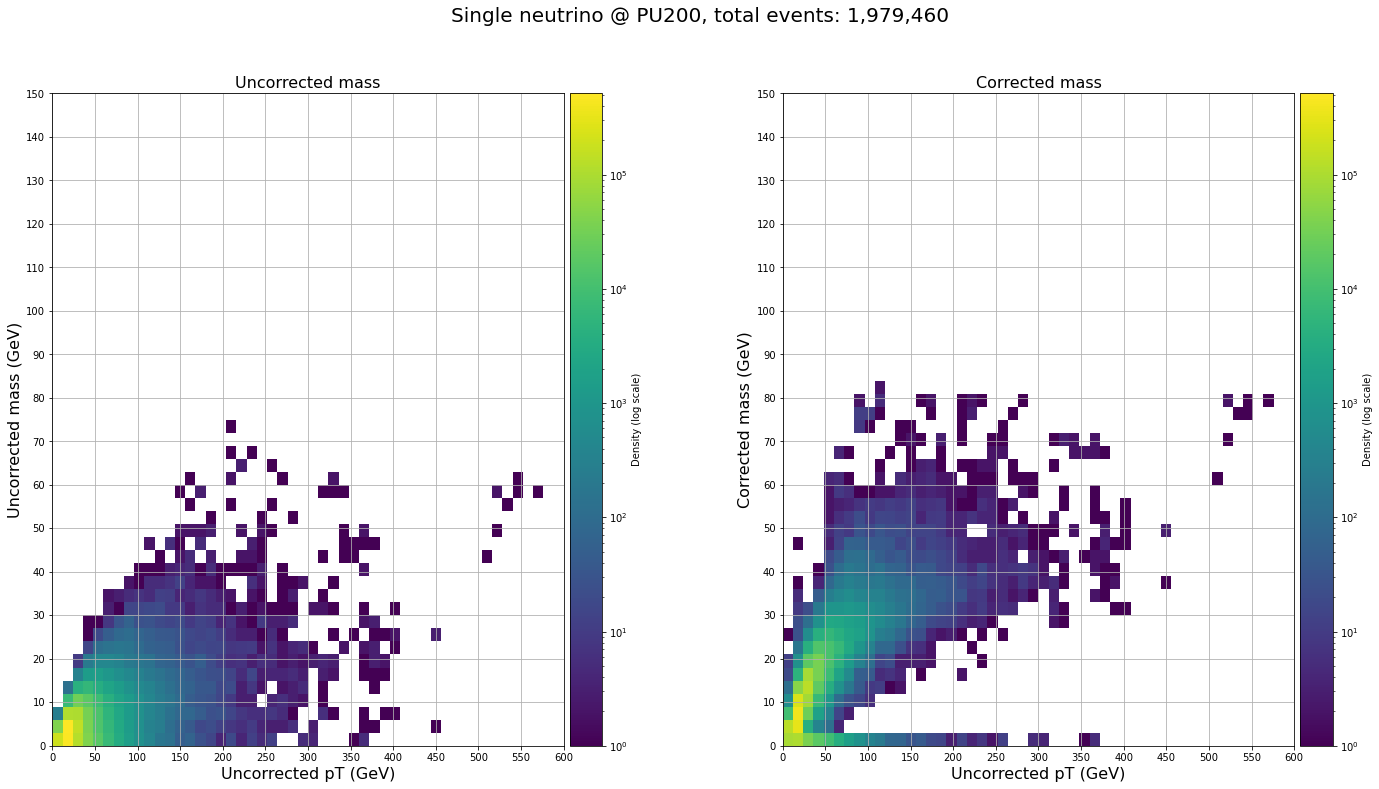

In [333]:
plot2d(bkg_corr)